# Submit Q# code to simulator/hardware via Azure Quantum

In this notebook, we'll review the basics of using Azure Quantum to submitting a simple quantum program, to IonQ simulator.

### 1. Connect to the Azure Quantum workspace

To connect to the Azure Quantum service, initialize the `Workspace` as seen below.

In [1]:
from azure.quantum import Workspace

workspace = Workspace(
            resource_id = "/subscriptions/006c31bd-51e0-41db-b622-d1d3f8e7213a/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/AQ-Demo",
            location = "westus")

We can use the resulting object to see which _targets_ are available for submission.

In [2]:
print("This workspace's targets:")
for target in workspace.get_targets():
    print("-", target.name)


This workspace's targets:
- ionq.qpu.aria-1
- ionq.qpu.aria-2
- ionq.simulator
- quantinuum.qpu.h1-1
- quantinuum.sim.h1-1sc
- quantinuum.sim.h1-1e
- rigetti.sim.qvm
- rigetti.qpu.ankaa-2
- microsoft.estimator


### ❕ Do you see `ionq.simulator` in your list of targets? If so, you're ready to keep going.

Don't see it? You may need to add IonQ to your workspace to run this sample. Navigate to the **Providers** page in the portal and click **+Add** to add the IonQ provider. Don't worry, there's a free credits plan available.

### 2. Build the quantum program

Here we'll use the Q# code for Grover's search from the first part of the workshop. This code will search for all bit strings with alternating bits, that is, bit strings 0101... and 1010...

First, let's initialize the Q# environment and set the target profile to Base Profile. Today, Azure Quantum targets only support the Base Profile, a subset of all Q# commands.

In [3]:
import qsharp
qsharp.init(target_profile=qsharp.TargetProfile.Base)


Q# initialized with configuration: {'targetProfile': 'base', 'languageFeatures': None, 'manifest': None}

In [4]:
%%qsharp
open Microsoft.Quantum.Convert;
open Microsoft.Quantum.Math;

operation AlternatingBitPairsOracle3(qs : Qubit[]) : Unit {
    within {
        for i in 0 .. Length(qs) - 2 {
            CNOT(qs[i], qs[i + 1]);
        }
    } apply {
        Controlled Z(qs[2...], qs[1]);
    }
}

operation GroversSearch(
    n : Int, 
    oracle : Qubit[] => Unit, 
    statePrep : Qubit[] => Unit is Adj,
    iterations : Int
) : Result[] {
    use qs = Qubit[n];
    // Prepare initial state: an even superposition of all basis states.
    statePrep(qs);

    for i in 1 .. iterations {
        // Apply the oracle.
        oracle(qs);
        
        // Reflect about the mean.
        within {
            Adjoint statePrep(qs);
            ApplyToEachA(X, qs);
        } apply {
            Controlled Z(qs[...n - 2], qs[n - 1]);
        }
    }
    return MResetEachZ(qs);
}

operation Main() : Result[] {
    let n = 3;
    let oracle = AlternatingBitPairsOracle3;
    let statePrep = ApplyToEachA(H, _);
    let iter = Round(PI() / 4.0 / ArcSin(2.0 / Sqrt(2.0^IntAsDouble(n))) - 0.5);
    return GroversSearch(n, oracle, statePrep, iter);
}


In [5]:
# Compile the qsharp operation
operation = qsharp.compile("Main()")


### 3. Submit the quantum program to IonQ

We will use the `target.submit` function to run the quantum program above on IonQ's `ionq.simulator` target. Your job will be packaged and sent to IonQ, where it will wait its turn to be run.

In [6]:
# Set the target to ionq.simulator
target = workspace.get_targets("ionq.simulator")

# Execute the job. We'll use 100 shots (simulated runs).
job = target.submit(operation, "Grover's search - alternating bits", shots=100)
print("Job Id:" + job.id)

result = job.get_results()


Job Id:7c2d8780-7565-11ef-b297-00155dc29e58
..........

The job ID can be used to retrieve the results later using the [get_job method](https://learn.microsoft.com/python/azure-quantum/azure.quantum.workspace?#azure-quantum-workspace-get-job) or by viewing it under the **Job management** section of the portal.

### 4. Visualize job results 
You can also view a histogram of the results using [`pyplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html):

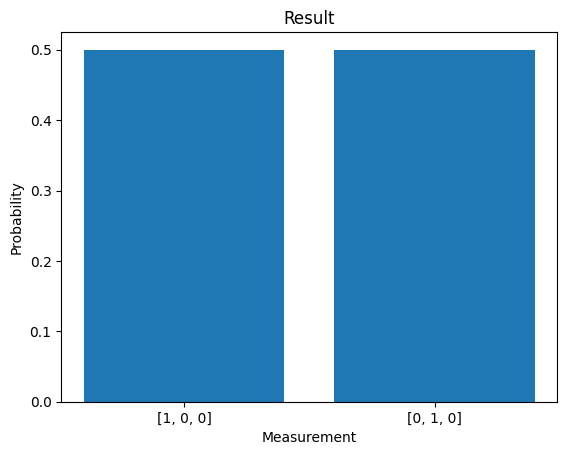

In [7]:
from matplotlib import pyplot

pyplot.bar(result.keys(), result.values())
pyplot.title("Result")
pyplot.xlabel("Measurement")
pyplot.ylabel("Probability")

pyplot.show()

